# Seminar 2. Linear regression

**Main source:** https://github.com/esokolov/ml-course-hse/blob/master/2021-fall/seminars/sem02-sklearn-linregr.ipynb

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter("ignore")
%matplotlib inline

sns.set(style="darkgrid")

# Часть 0. Введение в линейные модели

Напомним, что линейная регрессия &mdash; это модель следующего вида:
$$a(x) = \langle w, x \rangle + w_0$$
где $w \in \mathbb{R}^d$, $w_0 \in \mathbb{R}$. Обучить линейную регрессию &mdash; значит найти $w$ и $w_0$.

В машинном обучении часто говорят об *обобщающей способности модели*, то есть о способности модели работать на новых, тестовых данных хорошо. Если модель будет идеально предсказывать выборку, на которой она обучалась, но при этом просто ее запомнит, не "вытащив" из данных никакой закономерности, от нее будет мало толку. Такую модель называют *переобученной*: она слишком подстроилась под обучающие примеры, не выявив никакой полезной закономерности, которая позволила бы ей совершать хорошие предсказания на данных, которые она ранее не видела.

Рассмотрим следующий пример, на котором будет хорошо видно, что значит переобучение модели. Для этого нам понадобится сгенерировать синтетические данные. Рассмотрим зависимость $y(x) = \cos(1.5\pi x)$, $y$ &mdash; целевая переменная, а $x$ - объект (просто число от 0 до 1). В жизни мы наблюдаем какое-то конечное количество пар объект-таргет, поэтому смоделируем это, взяв 30 случайных точек $x_i$ в отрезке $[0;1]$. Более того, в реальной жизни целевая переменная может быть зашумленной (измерения в жизни не всегда точны), смоделируем это, зашумив значение функции нормальным шумом: $\tilde{y}_i = y(x_i) + \mathcal{N}(0, 0.01)$.

Попытаемся обучить три разных линейных модели: признаки для первой &mdash;  $\{x\}$, для второй &mdash; $\{x, x^2, x^3, x^4\}$, для третьей &mdash; $\{x, \dots, x^{20}\}$.

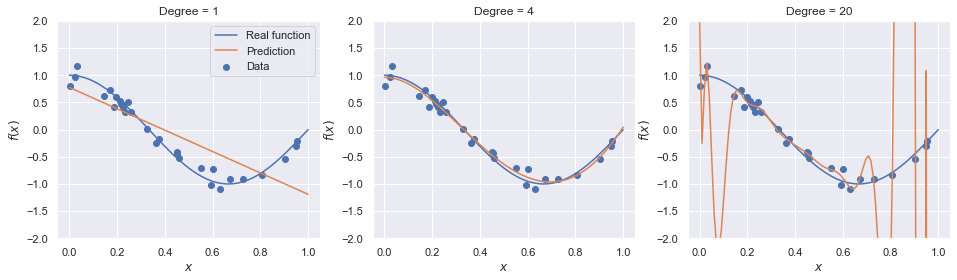

In [5]:
from sklearn.linear_model import LinearRegression

np.random.seed(36)
x = np.linspace(0, 1, 100)
y = np.cos(1.5 * np.pi * x)

x_objects = np.random.uniform(0, 1, size=30)
y_objects = np.cos(1.5 * np.pi * x_objects) + np.random.normal(scale=0.1, size=x_objects.shape)

from sklearn.preprocessing import PolynomialFeatures
fig, axs = plt.subplots(figsize=(16, 4), ncols=3)
for i, degree in enumerate([1, 4, 20]):
    X_objects = PolynomialFeatures(degree, include_bias=False).fit_transform(x_objects[:, None])
    X = PolynomialFeatures(degree, include_bias=False).fit_transform(x[:, None])
    regr = LinearRegression().fit(X_objects, y_objects)
    y_pred = regr.predict(X)
    axs[i].plot(x, y, label="Real function")
    axs[i].scatter(x_objects, y_objects, label="Data")
    axs[i].plot(x, y_pred, label="Prediction")
    if i == 0:
        axs[i].legend()
    axs[i].set_title("Degree = %d" % degree)
    axs[i].set_xlabel("$x$")
    axs[i].set_ylabel("$f(x)$")
    axs[i].set_ylim(-2, 2)

**Вопрос 1**: Почему первая модель получилась плохой, а третья переобучилась?

Чтобы избежать переобучения, модель регуляризуют. Обычно переобучения в линейных моделях связаны с большими весами, а поэтому модель часто штрафуют за большие значения весов, добавляя к функционалу качества, например, квадрат $\ell^2$-нормы вектора $w$:

$$Q_{reg}(X, y, a) = Q(X, y, a) + \lambda \|w\|_2^2$$

Это слагаемое называют $\ell_2$-регуляризатором, а коэффициент $\lambda$ &mdash; коэффициентом регуляризации. Более подробно о регуляризации и переобучении вы узнаете из лекций.

**Вопрос 2**: Почему большие веса в линейной модели &mdash; плохо?

**Вопрос 3**: Почему регуляризовать $w_0$ &mdash; плохая идея?

**Вопрос 4**: На что влияет коэффициент $\lambda$? Что будет происходить с моделью, если $\lambda$ начать уменьшать? Что будет, если $\lambda$ сделать слишком большим?

# Часть 1. Загружаем данные

Мы будем работать с данными из соревнования [House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview), в котором требовалось предсказать стоимость жилья. Давайте сначала загрузим и немного изучим данные (можно взять `train.csv` со страницы соревнования и переименовать в `train_sem2.csv`).

In [6]:
!wget  -O 'train_sem2.csv' -q 'https://www.dropbox.com/s/6dxq90t0prn2vaw/_train_sem2.csv?dl=0'

In [7]:
data = pd.read_csv("train_sem2.csv")

In [8]:
missings = data.isnull().mean()
missings[missings!=0]

LotFrontage     0.177397
Alley           0.937671
MasVnrType      0.005479
MasVnrArea      0.005479
BsmtQual        0.025342
BsmtCond        0.025342
BsmtExposure    0.026027
BsmtFinType1    0.025342
BsmtFinType2    0.026027
Electrical      0.000685
FireplaceQu     0.472603
GarageType      0.055479
GarageYrBlt     0.055479
GarageFinish    0.055479
GarageQual      0.055479
GarageCond      0.055479
PoolQC          0.995205
Fence           0.807534
MiscFeature     0.963014
dtype: float64

In [9]:
from sklearn.model_selection import train_test_split

data = data.drop(columns=["Id"])

y = data["SalePrice"]
X = data.drop(columns=["SalePrice"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12, shuffle=True)

Посмотрим сначала на значения целевой переменной.

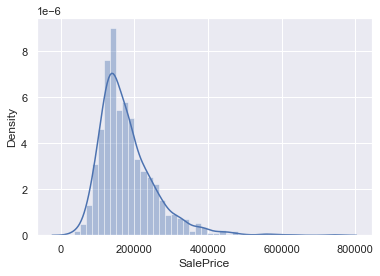

In [10]:
sns.distplot(y_train)
plt.show()

Судя по гистограмме, у нас есть примеры с нетипично большой стоимостью, что может помешать нам, если наша функция потерь слишком чувствительна к выбросам. В дальнейшем мы рассмотрим способы, как минимизировать ущерб от этого.

Так как для решения нашей задачи мы бы хотели обучить линейную регрессию, было бы хорошо найти признаки, "наиболее линейно" связанные с целевой переменной, иначе говоря, посмотреть на коэффициент корреляции Пирсона между признаками и целевой переменной. Заметим, что не все признаки являются числовыми, пока что мы не будем рассматривать такие признаки.

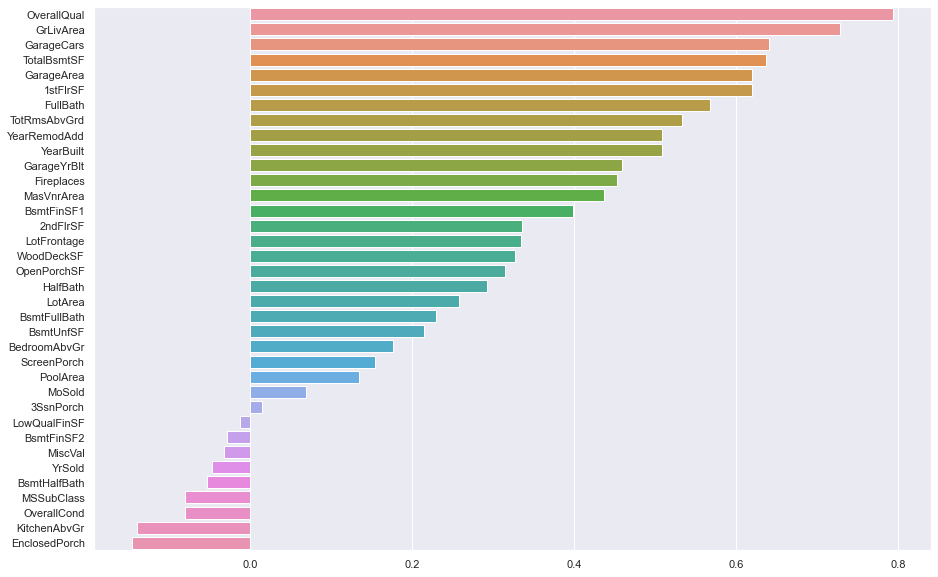

In [11]:
numeric_data = X_train.select_dtypes([np.number])
numeric_data_mean = numeric_data.mean()
numeric_features = numeric_data.columns

X_train = X_train.fillna(numeric_data_mean)
X_test = X_test.fillna(numeric_data_mean)

correlations = X_train[numeric_features].corrwith(y_train).sort_values(ascending=False)


plot = sns.barplot(y=correlations.index, x=correlations)
plot.figure.set_size_inches(15, 10)

Посмотрим на признаки из начала списка. Для этого нарисуем график зависимости целевой переменной от каждого из признаков. На этом графике каждая точка соответствует паре признак-таргет (такие графики называются scatter-plot).

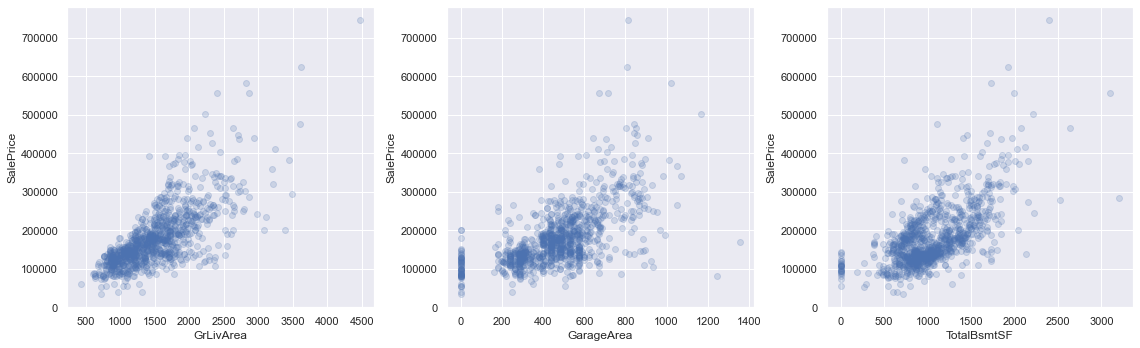

In [12]:
fig, axs = plt.subplots(figsize=(16, 5), ncols=3)
for i, feature in enumerate(["GrLivArea", "GarageArea", "TotalBsmtSF"]):
    axs[i].scatter(X_train[feature], y_train, alpha=0.2)
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel("SalePrice")
plt.tight_layout()

А что можно заметить в конце списка?

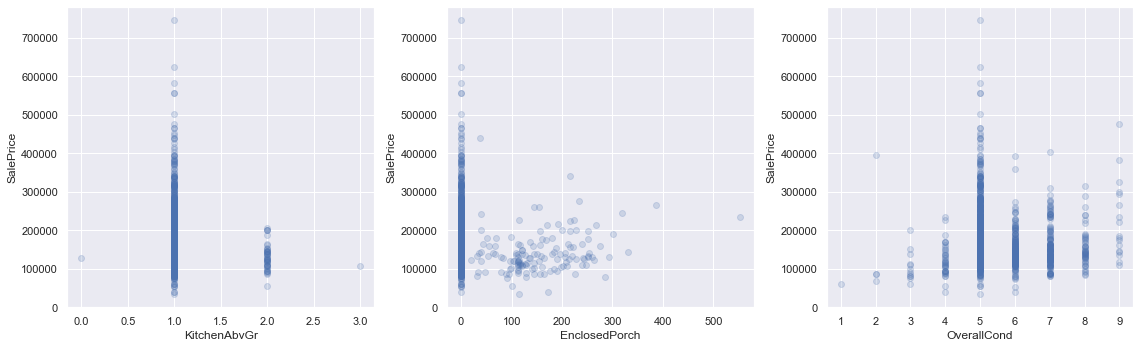

In [13]:
fig, axs = plt.subplots(figsize=(16, 5), ncols=3)
for i, feature in enumerate(["KitchenAbvGr", "EnclosedPorch", "OverallCond"]):
    axs[i].scatter(X_train[feature], y_train, alpha=0.2)
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel("SalePrice")
plt.tight_layout()

# Часть 2. Модель

Попробуем обучить линейную регрессию на числовых признаках из нашего датасета. В `sklearn` есть несколько классов, реализующих линейную регрессию:
* [`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) &mdash; "классическая" линейная регрессия с оптимизацией MSE. Веса находятся как точное решение: $w^* = (X^TX)^{-1}X^Ty$
* [`Ridge`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) &mdash; линейная регрессия с оптимизацией MSE и $\ell_2$-регуляризацией
* [`Lasso`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) &mdash; линейная регрессия с оптимизацией MSE и $\ell_1$-регуляризацией
* [`ElasticNet`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) &mdash; линейная регрессия с оптимизацией MSE и комбо $\ell_1$ и $\ell_2$-регуляризаций

У моделей из `sklearn` есть методы `fit` и `predict`. Первый принимает на вход обучающую выборку и вектор целевых переменных и обучает модель, второй, будучи вызванным после обучения модели, возвращает предсказание на выборке. Попробуем обучить нашу первую модель на числовых признаках, которые у нас сейчас есть:

In [14]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error as mse

model = Ridge()
model.fit(X_train[numeric_features], y_train)
y_pred = model.predict(X_test[numeric_features])
y_train_pred = model.predict(X_train[numeric_features])

print(f"Test RMSE = {mse(y_test, y_pred, squared=False):.2f}")
print(f"Train RMSE = {mse(y_train, y_train_pred, squared=False):.2f}")

Test RMSE = 49232.48
Train RMSE = 29091.00


Мы обучили первую модель и даже посчитали ее качество на отложенной выборке! Давайте теперь посмотрим на то, как можно оценить качество модели с помощью кросс-валидации. Принцип кросс-валидации изображен на рисунке

<img src="https://docs.splunk.com/images/thumb/e/ee/Kfold_cv_diagram.png/1200px-Kfold_cv_diagram.png" width=50%>

При кросс-валидации мы делим обучающую выборку на $n$ частей (fold). Затем мы обучаем $n$ моделей: каждая модель обучается при отсутствии соответствующего фолда, то есть $i$-ая модель обучается на всей обучающей выборке, кроме объектов, которые попали в $i$-ый фолд (out-of-fold). Затем мы измеряем качество $i$-ой модели на $i$-ом фолде. Так как он не участвовал в обучении этой модели, мы получим "честный результат". После этого, для получения финального значения метрики качества, мы можем усреднить полученные нами $n$ значений.

In [15]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_train[numeric_features], y_train, cv=10, scoring="neg_root_mean_squared_error")
print("Cross validation scores:\n\t", "\n", *cv_scores, "\n")
print(f"Mean CV MSE = {np.mean(-cv_scores):.2f}")

Cross validation scores:
	 
 -28132.044997317644 -26829.869015250028 -35934.310434453655 -24335.480226821568 -37740.83515565065 -27376.10462334034 -24923.655440708706 -38786.6999521182 -35623.59856671872 -27664.59228202907 

Mean CV MSE = 30734.72


Обратите внимание на то, что результаты `cv_scores` получились отрицательными. Это соглашение в `sklearn` (скоринговую функцию нужно максимизировать). Поэтому все стандартные скореры называются `neg_*`, например, `neg_root_mean_squared_error`.

Обратите внимание, что по отложенной выборке и при кросс-валидации мы считаем RMSE (Root Mean Squared Error), хотя в функционале ошибки при обучении модели используется MSE.

$$\text{RMSE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} (y_i - a(x_i))^2}$$

Если бы RMSE не входил в стандартные метрики `sklearn`, можно было бы его определить через функцию `sklearn.metrics.make_scorer`. 

In [16]:
from sklearn.metrics import make_scorer

def rmse(y_true, y_pred):
    error = (y_true - y_pred) ** 2
    return np.sqrt(np.mean(error))

rmse_scorer = make_scorer(
    rmse,
    greater_is_better=False # то есть это функция потерь, которую хотим минимизировать
)

In [17]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_train[numeric_features], y_train, cv=10, scoring=rmse_scorer)
print("Cross validation scores:\n\t", "\n", *cv_scores, "\n")
print(f"Mean CV MSE = {np.mean(-cv_scores):.2f}")

Cross validation scores:
	 
 -28132.044997317633 -26829.869015250028 -35934.31043445366 -24335.480226821568 -37740.83515565064 -27376.10462334034 -24923.655440708713 -38786.699952118186 -35623.59856671871 -27664.592282029065 

Mean CV MSE = 30734.72


Для того, чтобы иметь некоторую точку отсчета, удобно посчитать оптимальное значение функции потерь при константном предсказании.

**Вопрос**: Чему равна оптимальная константа для RMSE?

In [18]:
best_constant = #

print(f"Test RMSE with best constant = {}")
print(f"Train RMSE with best constant = {}")

SyntaxError: invalid syntax (<ipython-input-18-7ae47bfab0ee>, line 1)

Посмотрим на веса модели

In [25]:
def show_weights(features, weights, scales):
    fig, axs = plt.subplots(figsize=(14, 10), ncols=2)
    sorted_weights = sorted(zip(weights, features, scales), reverse=True)
    weights = [x[0] for x in sorted_weights]
    features = [x[1] for x in sorted_weights]
    scales = [x[2] for x in sorted_weights]
    sns.barplot(y=features, x=weights, ax=axs[0])
    axs[0].set_xlabel("Weight")
    sns.barplot(y=features, x=scales, ax=axs[1])
    axs[1].set_xlabel("Scale")
    plt.tight_layout()

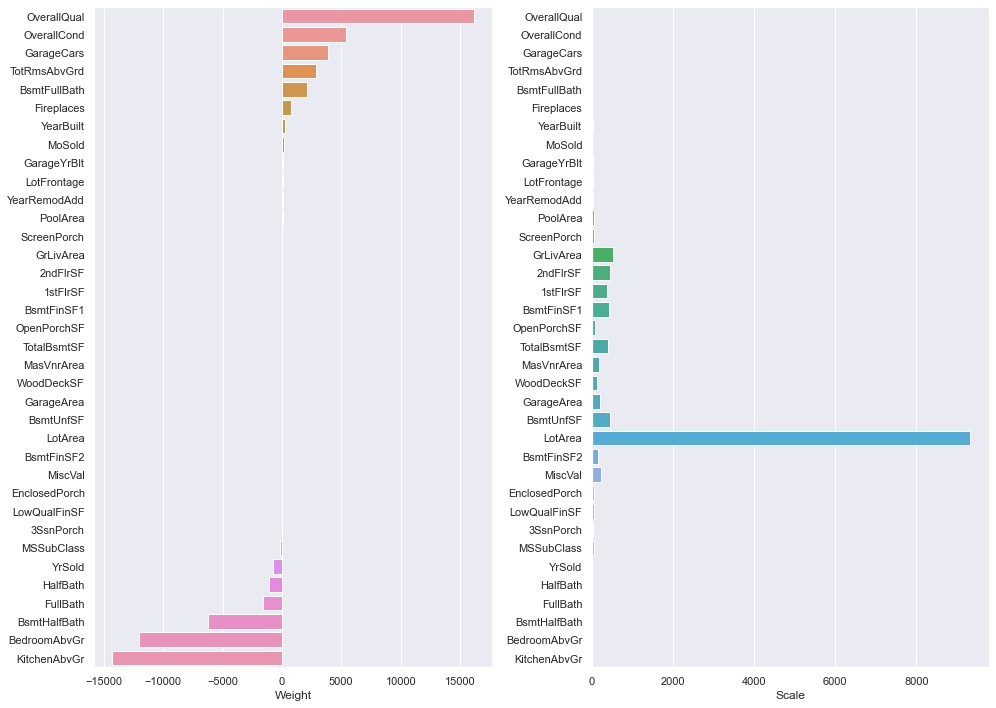

In [26]:
show_weights(numeric_features, model.coef_, X_train[numeric_features].std())

Будем масштабировать наши признаки перед обучением модели. Это, среди, прочего, сделает нашу регуляризацию более честной: теперь все признаки будут регуляризоваться в равной степени. 

Для этого воспользуемся трансформером [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). Трансформеры в `sklearn` имеют методы `fit` и `transform` (а еще `fit_transform`). Метод `fit` принимает на вход обучающую выборку и считает по ней необходимые значения (например статистики, как `StandardScaler`: среднее и стандартное отклонение каждого из признаков). `transform` применяет преобразование к переданной выборке.

In [27]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_features])
X_test_scaled = scaler.transform(X_test[numeric_features])

model = Ridge()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
y_train_pred = model.predict(X_train_scaled)

print(f"Test RMSE = {mse(y_test, y_pred, squared=False):.2f}")
print(f"Train RMSE = {mse(y_train, y_train_pred, squared=False):.2f}")

Test RMSE = 49218.30
Train RMSE = 29090.91


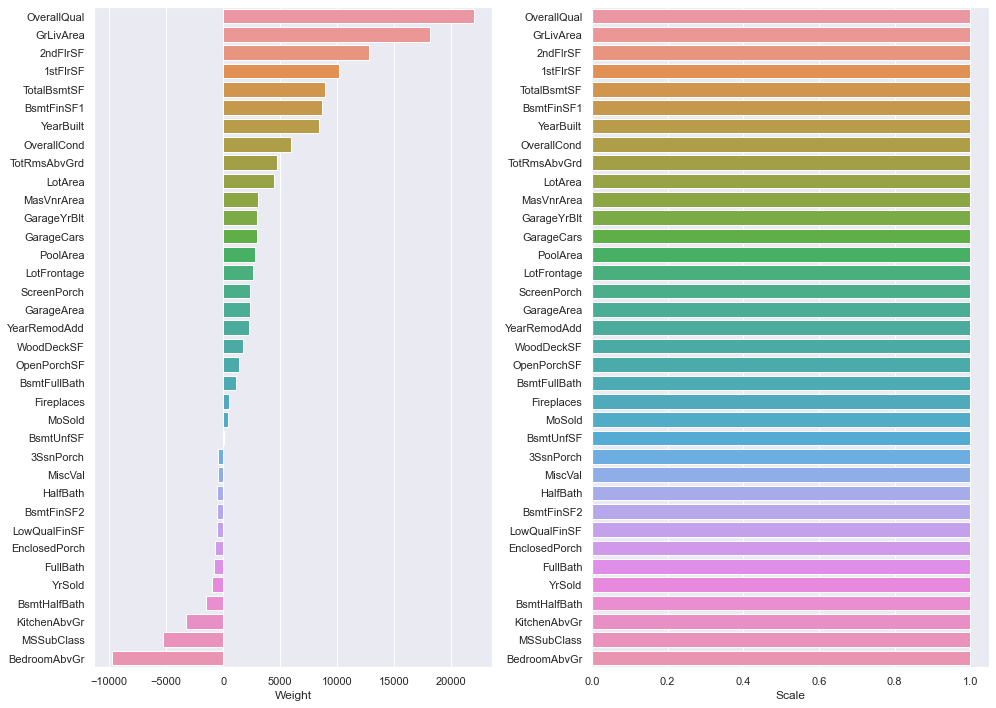

In [28]:
scales = pd.Series(data=X_train_scaled.std(axis=0), index=numeric_features)
show_weights(numeric_features, model.coef_, scales)

Наряду с параметрами (веса $w$, $w_0$), которые модель оптимизирует на этапе обучения, у модели есть и гиперпараметры. У нашей модели это `alpha` &mdash; коэффициент регуляризации. Подбирают его обычно по сетке, измеряя качество на валидационной (не тестовой) выборке или с помощью кросс-валидации. Посмотрим, как это можно сделать (заметьте, что мы перебираем `alpha` по логарифмической сетке, чтобы узнать оптимальный порядок величины).

Best alpha = 48


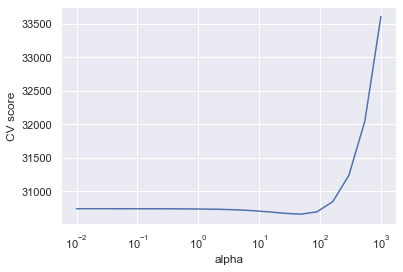

In [29]:
from sklearn.model_selection import GridSearchCV

alphas = np.logspace(-2, 3, 20)
searcher = GridSearchCV(Ridge(), [{"alpha": alphas}], scoring="neg_root_mean_squared_error", cv=10)
searcher.fit(X_train_scaled, y_train)

best_alpha = searcher.best_params_["alpha"]
print(f"Best alpha = {best_alpha:.0f}")

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")
plt.show()

Попробуем обучить модель с подобранным коэффициентом регуляризации. Заодно воспользуемся очень удобным классом [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): обучение модели часто представляется как последовательность некоторых действий с обучающей и тестовой выборками (например, сначала нужно отмасштабировать выборку (причем для обучающей выборки нужно применить метод `fit`, а для тестовой &mdash; `transform`), а затем обучить/применить модель (для обучающей `fit`, а для тестовой &mdash; `predict`). `Pipeline` позволяет хранить эту последовательность шагов и корректно обрабатывает разные типы выборок: и обучающую, и тестовую.

In [30]:
from sklearn.pipeline import Pipeline

simple_pipeline = Pipeline([
    ('scaling', StandardScaler()),
    ('regression', Ridge(best_alpha))
])

model = simple_pipeline.fit(X_train[numeric_features], y_train)
y_pred = model.predict(X_test[numeric_features])
print(f"Test RMSE = {mse(y_test, y_pred, squared=False):.2f}")

Test RMSE = 48529.51


# Часть 3. Работаем с категориальными признаками

Сейчас мы явно вытягиваем из данных не всю информацию, что у нас есть, просто потому, что мы не используем часть признаков. Эти признаки в датасете закодированы строками, каждый из них обозначает некоторую категорию. Такие признаки называются категориальными. Давайте выделим такие признаки и сразу заполним пропуски в них специальным значением (то, что у признака пропущено значение, само по себе может быть хорошим признаком).

In [31]:
categorical = list(X_train.dtypes[X_train.dtypes == "object"].index)
X_train[categorical] = X_train[categorical].fillna("NotGiven")
X_test[categorical] = X_test[categorical].fillna("NotGiven")

In [32]:
X_train[categorical].sample(5)

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
402,RL,Pave,NotGiven,Reg,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,...,Detchd,Unf,TA,TA,N,NotGiven,GdPrv,NotGiven,WD,Normal
1232,RL,Pave,NotGiven,Reg,Lvl,AllPub,FR2,Gtl,NAmes,Norm,...,CarPort,Unf,TA,TA,Y,NotGiven,NotGiven,NotGiven,WD,Normal
7,RL,Pave,NotGiven,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,...,Attchd,RFn,TA,TA,Y,NotGiven,NotGiven,Shed,WD,Normal
1419,RL,Pave,NotGiven,IR1,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,...,Attchd,RFn,TA,TA,Y,NotGiven,NotGiven,NotGiven,WD,Normal
708,RL,Pave,NotGiven,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,...,Attchd,Fin,TA,TA,Y,NotGiven,NotGiven,NotGiven,New,Partial


Сейчас нам нужно как-то закодировать эти категориальные признаки числами, ведь линейная модель не может работать с такими абстракциями. Два стандартных трансформера из `sklearn` для работы с категориальными признаками &mdash; [`OrdinalEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) (просто перенумеровывает значения признака натуральными числами) и [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html).

`OneHotEncoder` ставит в соответствие каждому признаку целый вектор, состоящий из нулей и одной единицы (которая стоит на месте, соответствующем принимаемому значению, таким образом кодируя его).

**Вопрос**: Проинтерпретируйте, что означают веса модели перед OneHot-кодированными признаками. Почему пользоваться `OrdinalEncoder` в случае линейной модели &mdash; скорее плохой вариант? Какие недостатки есть у OneHot-кодирования?

In [33]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Test RMSE = {mse(y_test, y_pred, squared=False):.2f}")

Test RMSE = 47041.36


Посмотрим на размеры матрицы после OneHot-кодирования:

In [25]:
print("Size before OneHot:", X_train.shape)
print("Size after OneHot:", column_transformer.transform(X_train).shape)

Size before OneHot: (1022, 79)
Size after OneHot: (1022, 295)


Как видим, количество признаков увеличилось более, чем в 3 раза. Это может повысить риски переобучиться: соотношение количества объектов к количеству признаков сильно сократилось.

Попытаемся обучить линейную регрессию с $\ell_1$-регуляризатором. Такой регуляризатор разреживает признаковое пространство, иными словами, модель зануляет часть весов.

In [39]:
from sklearn.linear_model import Lasso

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

lasso_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso())
])

model = lasso_pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Test RMSE = {mse(y_test, y_pred, squared=False):.2f}")

Test RMSE = 40381.39


In [40]:
ridge_zeros = np.sum(pipeline['regression'].coef_ == 0)
lasso_zeros = np.sum(lasso_pipeline['regression'].coef_ == 0)
print(f"Zero weights in Ridge: {ridge_zeros}")
print(f"Zero weights in Lasso: {lasso_zeros}")

Zero weights in Ridge: 0
Zero weights in Lasso: 34


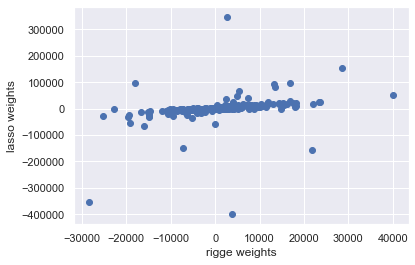

In [41]:
plt.scatter(pipeline['regression'].coef_, lasso_pipeline['regression'].coef_)
plt.xlabel('rigge weights')
plt.ylabel('lasso weights')
plt.show()

Подберем для нашей модели оптимальный коэффициент регуляризации. Обратите внимание, как перебираются параметры у `Pipeline`.

Best alpha = 127.42749857031322:.4f


Text(0, 0.5, 'CV score')

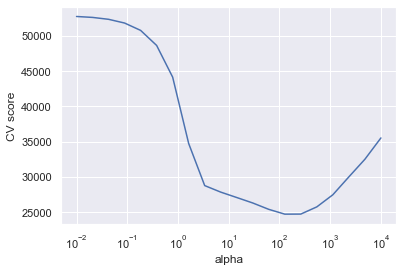

In [42]:
alphas = np.logspace(-2, 4, 20)
searcher = GridSearchCV(lasso_pipeline, [{"regression__alpha": alphas}],
                        scoring="neg_root_mean_squared_error", cv=10, n_jobs=-1)
searcher.fit(X_train, y_train)

best_alpha = searcher.best_params_["regression__alpha"]
print(f"Best alpha = {best_alpha}:.4f" )

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

In [68]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso(best_alpha))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Test RMSE = {mse(y_test, y_pred, squared=False):.2f}")

Test RMSE = 45499.27


In [74]:
lasso_zeros = np.sum(pipeline['regression'].coef_ == 0)
print(f"Zero weights in Lasso: {lasso_zeros}")

Zero weights in Lasso: 63


In [75]:
pipeline['ohe_and_scaling'].

SyntaxError: invalid syntax (<ipython-input-75-f6429f1c135d>, line 1)

Иногда бывает полезно посмотреть на распределение остатков. С его помощью можно заметить выбросы, которые стоит отфильтровать, или, если таких объектов много, задуматься, как улучшить модель. 

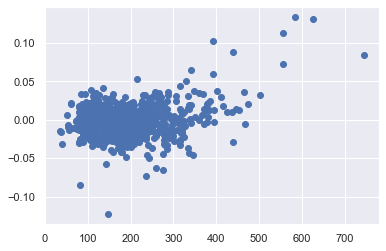

In [76]:
error = (y_train - model.predict(X_train))/1000
plt.scatter(y_train/1000, error/1000)
plt.show()

### Логарифмирование целевой переменной

Иногда может помочь преобразование целевой переменной. Может оказаться, что по мере роста признаков целевая переменная меняется экспоненциально. Например, может оказаться, что при линейном уменьшении продолжительности видео число его просмотров растёт экспоненциально. Учеть это можно с помощью логарифмирования целевой переменной — ниже синтетический пример с такой ситуацией.

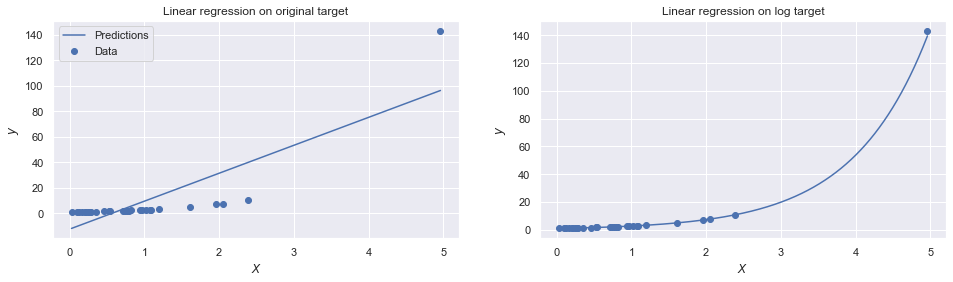

In [77]:
X = np.random.exponential(1, size=30)
y = np.exp(X) + np.random.normal(scale=0.1, size=X.shape)

x_plot = np.linspace(np.min(X), np.max(X), 10000)

fig, axs = plt.subplots(figsize=(16, 4), ncols=2)

regr = LinearRegression()
regr.fit(X[:, np.newaxis], y)
y_pred_regr = regr.predict(x_plot[:, np.newaxis])
axs[0].scatter(X[:, np.newaxis], y, label="Data")
axs[0].plot(x_plot, y_pred_regr, label="Predictions")
axs[0].legend()
axs[0].set_title("Linear regression on original target")
axs[0].set_xlabel("$X$")
axs[0].set_ylabel("$y$")

y_log = np.log(y)
regr.fit(X[:, np.newaxis], y_log)
y_pred_log = np.exp(regr.predict(x_plot[:, np.newaxis]))
axs[1].scatter(X[:, np.newaxis], y, label="Data")
axs[1].plot(x_plot, y_pred_log, label="Predictions")
axs[1].set_title("Linear regression on log target")
axs[1].set_xlabel("$X$")
axs[1].set_ylabel("$y$")
plt.show()

### QA

[`Learning curve`](https://mlcourse.ai/articles/topic4-part5-validation/)